# ARIMA Models for Time Series
## Data Science Tools I
### Terron Ishihara and Don Dalton | University of Denver


---

This notebook covers the use of ARIMA models for forecasting time series. ARIMA is the standard for handling time series data and while much of this process can be done automatically, it is worth understanding what's going on more under the hood.

## Box-Jenkins Method

The overall approach we follow here is the Box-Jenkins Method:

1.   Model Identification/Selection
2.   Parameter Estimation
3.   Statistical Model Checking



## Properties of Time Series

When considering time series, we typically are talking about *univariate* time series, i.e. one variable changing over time. Certain patterns can emerge in a time series, which are some combination of:

> **Trend**: A long-term increase or decrease over time

> **Seasonality**: Patterns repeats over successive periods of time

Once we have made our forecast, we also have residuals:

> **Residuals**: The difference between the forecasted prediction and the actual value

From trend and seasonality we observe the patterns horizontal (no trend, no seasonality), trend, seasonal without trend, and seasonal with trend. While there are methods for forecasting all of these (as we saw last lecture), the most reliable methods can only be applied to stationary time series. These time series have a horizontal pattern, which is desirable because of its predictability (no trend and no seasonality means we can be confident about what will come next).

> **Stationarity**: Constant statistical properties (mean, variance, autocorrelation, etc.), not dependent on time

These methods are the focus of this lecture and are all variations of the general ARIMA model. To get to the point where we can apply the ARIMA model, we must first understand how to force a time series to be stationary.

Before we get into it, let's import some libraries we'll need and import a dataset to use as an example.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# plt.rc('figure', figsize=(8, 8))

import seaborn as sns
# sns.set_context('talk')

# Suppress warnings to prevent verbose output
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pydataset

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for pydataset, since package 'wheel' is not installed.
    Running setup.py install for pydataset: started
    Running setup.py install for pydataset: finished with status 'done'


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
import pydataset

air = pydataset.data("AirPassengers")
air.rename(columns={'AirPassengers': 'passengers'}, inplace=True)

# series['time'] = series['time'].apply(decimal_year_to_datetime)
air.set_index('time', inplace=True)

series = air
series.head()

initiated datasets repo at: C:\Users\bisho\.pydataset/


,passengers
time,
1949.000000,112
1949.083333,118
1949.166667,132
1949.250000,129
1949.333333,121


<AxesSubplot:xlabel='time'>

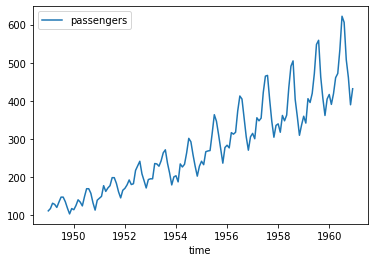

In [4]:
series.plot()

## Checking Properties with Seasonal Decompose

The trend, seasonality, and residuals of a time series can be automatically extracted using the `seasonal_decompose` function in `statsmodels`. The resulting plot can allow you to more concretely observe each of these properties in the series.

In order for `seasonal_decompose` to work properly, the timestamps must be in Datetime format, which is Python's/Pandas' way of representing time-related values. Pandas provides a `to_datetime` method for performing this conversion automatically on strings, though sometimes the formatting of the string cannot be automatically inferred. In this case, we also cannot manually type the format string (e.g. "%Y-%m-%d" for a string like "1996-02-27") since the month is given as a decimal (month / 12). Hence, we have a little extra data cleaning to do to get this in the right format.

In [5]:
# Timestamps are provided in the format YYYY.ddd where YYYY is the year
# is the month divided 12 as a decimal.
def decimal_year_to_datetime(time):
  year = int(time)
  remainder = time - year
  month = round(remainder * 12) + 1
  return pd.to_datetime(str(year)+str(month), format='%Y%m')

In [6]:
series_with_datetime = series.copy()

# series.index.values is a numpy array, so put into Series
# so we can use the apply function with our function
times = pd.Series(series.index.values)
times = times.apply(decimal_year_to_datetime)

# Set the index to the newly formatted datetimes
series_with_datetime.index = times
series_with_datetime.index.name = 'time'
series_with_datetime.head()

,passengers
time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


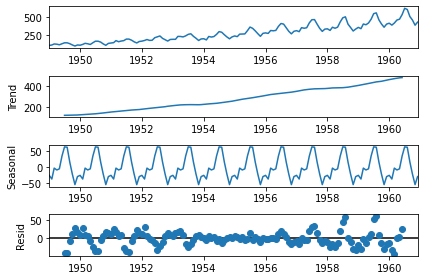

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(series_with_datetime).plot();

Based on the above plot, we can see that
* there is a linear trend
* there is a seasonality component
* the residuals are not like white noise since the variance (amplitude) changes over time

As a result, this series is pretty clearly not stationary.

# Checking for Stationarity

A time series is considered (weakly) stationary if:
* it has a constant mean at all time points
* it has a constant variance at all time points
* the covariance between time $t$ and its lag $t-k$ is constant for all times

We will not go into too much detail on the exact definitions and meanings of each statistical attribute in this lecture. Here we will focus more on how to use the tools available to us to design an ARIMA model for time series forecasting.

The "base" example of a stationary process is **white noise**, where every value is randomly generated with zero  mean and constant variance. An example plot of this is given below.

<AxesSubplot:>

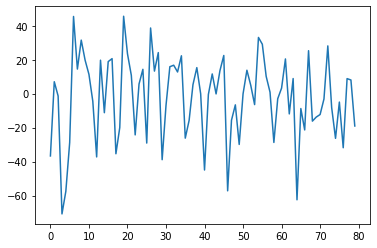

In [8]:
white_noise = pd.Series(np.random.randn(80) * 20)
white_noise.plot()

This is the sort of plot we are hoping for before we apply the ARIMA model. That is, we want a time series that has:
* constant mean and variance
* no seasonality and no trends

Another way to view this is as a process with some constant mean $\mu$ with white noise for the residuals. Our ARIMA model should look like white noise centered at some mean.

There are two ways of determining if a time series is stationary or not, either visually using rolling statistics or mathematically with the Augmented Dickey-Fuller Test.

## Rolling Statistics

Recall the idea of a moving average, where we compute the average of the last $p$ values, either as a forecast itself or as a means of smoothing the data. This is generally referred to as a "rolling statistic". The value of $p$ is the size of a sliding window across the data to which a given statistic (mean, variance, etc.) is applied. Doing so and then plotting the resulting statistic alongside the data can visually indicate if that statistic remains constant or not. If not, the time series is not stationary.

Pandas has an easy means of doing this. The `rolling(window)` method can be called on a series with a given size for the window. The exact integer used is not of too much significance; a meaningful value could be something like 12 if, for example, the data is given in months.

In [9]:
# This dataset is in months, so a window of size 12 is one year
rolling_mean = series.rolling(window=12).mean()
rolling_std = series.rolling(window=12).std()
rolling_mean.head(14)

,passengers
time,
1949.000000,NaN
1949.083333,NaN
1949.166667,NaN
1949.250000,NaN
1949.333333,NaN
1949.416667,NaN
1949.500000,NaN
1949.583333,NaN
1949.666667,NaN


Notice above that the first 11 values are NaN since there are not 12 values at those time points to compute a mean. We can now plot these statistics on top of a plot of the data itself to more clearly observe any changes in mean over time.

<AxesSubplot:xlabel='time', ylabel='passengers'>

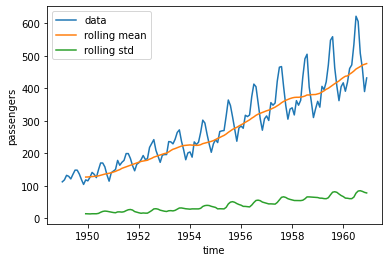

In [10]:
sns.lineplot(series.index, series['passengers'], label='data')
sns.lineplot(rolling_mean.index, rolling_mean['passengers'], label='rolling mean')
sns.lineplot(rolling_std.index, rolling_std['passengers'], label='rolling std')

We would conclude from the above plot that this dataset is not stationary since the mean and standard deviation change (increase) over time.

## Augmented Dickey-Fuller Test

Since a visual interpretation cannot be automated and (more importantly) is subjective, a statistical test is more practical in some situations. This is where the Augmented Dickey-Fuller Test comes in. Again, we are not going into the finer details of the statistical aspects here. Rather, this is simply another tool for checking for stationarity.

Simply put, if the critical values are less than the test statistic, the series is not stationary. In more formal terms, we cannot reject the null hypothesis that the series is not stationary. (I know that's a double- or triple-negative, but that's how stats language is.) This is further confirmed by a relatively high p-value. A **p-value closer to 0.05** or less would indicate otherwise (that the series is stationary). 

In [11]:
from statsmodels.tsa.stattools import adfuller

def run_adftest(s):
  print("Dickey-Fuller Test")
  adftest = adfuller(s, autolag='AIC')
  print(f"Test Statistic: {adftest[0]}")
  print(f"p-value: {adftest[1]}")
  print("Critical Values:")
  for k, v in adftest[4].items():
      print("\t{}: {} - The data is{} stationary with {}% confidence".format(k, v, " not" if v<adftest[0] else "", 100-int(k[:-1])))

run_adftest(series['passengers'])

Dickey-Fuller Test
Test Statistic: 0.8153688792060433
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is not stationary with 95% confidence
	10%: -2.578770059171598 - The data is not stationary with 90% confidence


# Enforcing Stationarity (I)

In order to stationarize a time series, there are a few options, but we will mostly focus on differencing.

> **Differencing**: Seasonal/cyclical patterns can be removed by substracting periodical values. This follows the logic that each value is related to (dependent on) the one or two values before it.

> **De-trending**: Removing the underlying trend. 
  * Dividing the series by an already known index (like deflating a currency to account for inflation) is one method. 
  * If the index is not known, the trend can be estimated as, say, linear or exponential, then each term can be subtracted by it's corresponding model. 
  * If the trend reflects a compound rate (like interest), taking the log (logarithm) of each data point can linearize the data, which can then allow you to try the above approaches.



## Differencing

Differencing is a method built into Pandas, but to get a better understanding of what's going on, let's manually compute the series with various shift values. The shift can be positive (shift "down") or negative (shift "up"). the shifted data is referred to as a **lag** of a particular shift value. Here we create a data frame to illustrate lags 1 through 5 side-by-side.

In [12]:
lags = series.copy()
for i in range(1, 6):
  lags[f'lag{i}'] = series.shift(i)
lags.head(6)

,passengers,lag1,lag2,lag3,lag4,lag5
time,,,,,,
1949.000000,112,NaN,NaN,NaN,NaN,NaN
1949.083333,118,112.0,NaN,NaN,NaN,NaN
1949.166667,132,118.0,112.0,NaN,NaN,NaN
1949.250000,129,132.0,118.0,112.0,NaN,NaN
1949.333333,121,129.0,132.0,118.0,112.0,NaN
1949.416667,135,121.0,129.0,132.0,118.0,112.0


Calling the `diff()` method on a series will shift the data by the given amount (default 1) and element-wise subtract the shifted data from the original. Here's a simple example.

In [13]:
series['passengers'].diff(periods=1).head()

time
1949.000000     NaN
1949.083333     6.0
1949.166667    14.0
1949.250000    -3.0
1949.333333    -8.0
Name: passengers, dtype: float64

Given this, the question is what the best shift value is for differencing our data such that it is nearly stationary. The word "nearly" is hinting at the concept that we can potentially **over-difference** which leads to a non-stationary series.

The tool for determining this shift value is called the **autocorrelation function (ACF)**. Mathematical details aside, this function produces a value that indicates how correlated the data is with itself (hence the "auto" prefix). Naturally, the raw data autocorrelated with itself *unshifted* will produce a value of 1 since the values are one-to-one (perfectly correlated). 

What we're interested in is the values of autocorrelation of the data with its lags. This is particularly useful for identifying the *seasonality* of the data. If the data is given as quarterly values, for example, a given season is likely of size 4. So, lags of size 4, 8, 12, and so on should have higher autocorrelation values since seasonal patterns are similar.

Worth noting is that the ACF function incorporates as part of its calculation the intermediate lags as well. For example, the autocorrelation between a series and its order-4 lag would have contributions from lags 1 through 3 as well. This is distinct from the **partial autocorrelation function** which does not include the intermediate lags.

The ACF plot can be used to detect seaonality and trends as we did in the original plot of the data, but from a different perspective.

> **Regular highly positive spikes** in the autocorrelation plot are an indication of **seasonality**.

> **Higher autocorrelations for smallers lags** (the first few) are an indication that a **trend** exists in the series.

<BarContainer object of 41 artists>

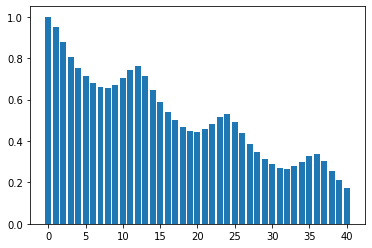

In [14]:
# If you want to see the values of the ACF, you can perform the calculation
# first using the acf function, then plot it manually.
from statsmodels.tsa.stattools import acf

# The use of 40 for nlags is not significant, we just want to see a good amount
autocorr = acf(series, nlags=40)
plt.bar(range(len(autocorr)), autocorr)

We can see from the above plot that each season is indeed around size 12, where each of the positive spikes are. Additionally, the high autocorrelation for the first lags is an indication that a trend exists.

For a stationary series, the autocorrelation plot using `plot_acf` should have most values near zero, in the highlighted area. This series is not stationary because there are many high autocorrelation values for the first 10 lags or so, and there is a gradual decay to 0.

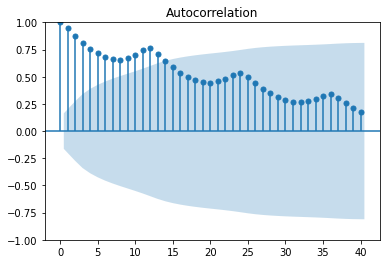

In [15]:
# If you only want to plot, you can use plot_acf instead (from a different package)
from statsmodels.graphics.tsaplots import plot_acf

# The semi-colon prevents the plot from appearing twice (for some reason??)
plot_acf(series, lags=40);

Now let's try differencing the series and observe the autocorrelation plot again. To start, let's try a difference of 1.

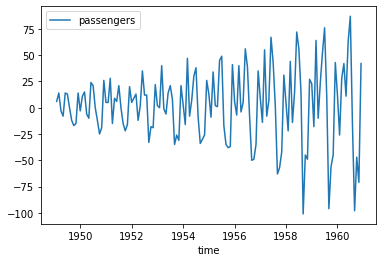

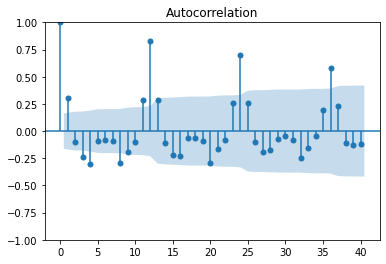

In [16]:
diffed_series = series.diff() # default periods value of 1
diffed_series.plot()

# Since the shift causes NaN to appear as the first k values,
# we drop the null values before performing calculations
plot_acf(diffed_series.dropna(), lags=40);

This is better, though still with some spikes. If you try the same with difference order 2 (the ARIMA model in `statsmodels` does not allow orders greater than 2), the plot is almost the same, so we'll stick with order 1.

Let's try running the Dickey-Fuller test to see how stationary this differenced series is.

In [17]:
run_adftest(diffed_series['passengers'].dropna())

Dickey-Fuller Test
Test Statistic: -2.8292668241699954
p-value: 0.05421329028382609
Critical Values:
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is not stationary with 95% confidence
	10%: -2.578770059171598 - The data is stationary with 90% confidence


Although we are near-stationary, this does not seem close enough. Perhaps we need to try another transformation to the data.

## De-Trending 

The overall approach to de-trending a series is not a standarized one. It is essentially trial-and-error, though hopefully guided by some intuitions you have about the over trend in the data.

A key thing to keep in mind is that any transformation performed while de-trending must be undone when making predictions. For example, taking the log of the series is undone by exponentiating the predicted values.

Here, we can see that there is a linear trend in the data. `np.polyfit` with degree 1 will compute this model for you in the form

$$
y_t = mt+b
$$

and return $m$ and $b$ respectively in an array.

The question is how to use this model to augment the data and remove the trend.

> **Additive trend**: Mean changes over time, variance remains constant. Try subtracting the best fit model.

> **Multiplicative trend**: Mean and variance change over time. Try dividing by the best fit model.

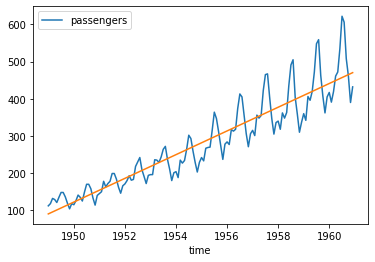

In [18]:
# Fit linear model to data
m, b = np.polyfit(x=series.index.values, y=series.passengers, deg=1)

# Plot results
series.plot()
plt.plot(series.index.values, series.index.values * m + b)

Since this dataset appears to have both increasing mean and variance over time, let's try dividing the best fit model.

<AxesSubplot:xlabel='time'>

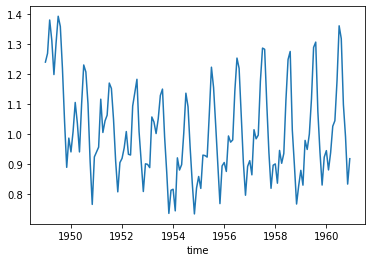

In [19]:
detrended_series = series.passengers / (m * series.index.values + b)
detrended_series.plot()

<AxesSubplot:xlabel='time'>

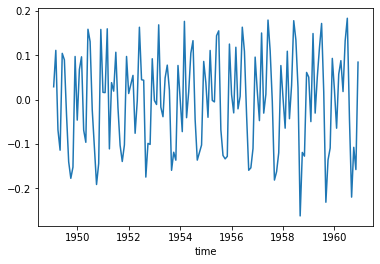

In [20]:
diffed_detrended_series = detrended_series.diff(periods=1)
diffed_detrended_series.plot()

Let's check stationarity with the ACF plot and Dickey-Fuller test.

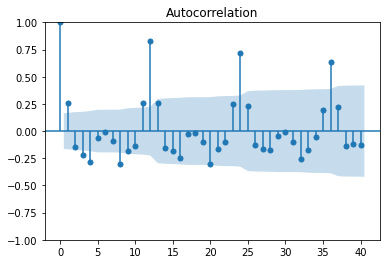

In [21]:
plot_acf(diffed_detrended_series.dropna(), lags=40);

In [22]:
run_adftest(diffed_detrended_series.dropna())

Dickey-Fuller Test
Test Statistic: -3.7687301223683938
p-value: 0.0032439482637220073
Critical Values:
	1%: -3.4825006939887997 - The data is stationary with 99% confidence
	5%: -2.884397984161377 - The data is stationary with 95% confidence
	10%: -2.578960197753906 - The data is stationary with 90% confidence


# Another Example - Min Temperature

Let's try the same idea on another dataset. This one measures the minimum daily temperature in Melbourne over the years 1981 to 1990.

In [23]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
temperature = pd.read_csv(url)
temperature['Date'] = pd.to_datetime(temperature['Date'], format='%Y-%m-%d')
temperature.rename(columns={'Date': 'date', 'Temp': 'temp'}, inplace=True)
temperature.set_index('date', inplace=True)
temperature.head()

,temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


First let's plot the data to observe any patterns.

<AxesSubplot:xlabel='Day', ylabel='Min Temperature'>

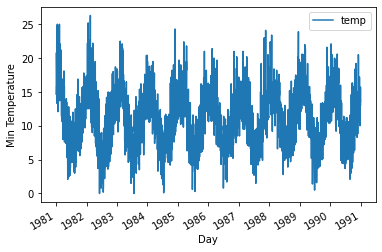

In [24]:
temperature.plot(xlabel='Day', ylabel='Min Temperature')

This looks like a seasonal pattern, but without any trend.

Let's look at the ACF plot.

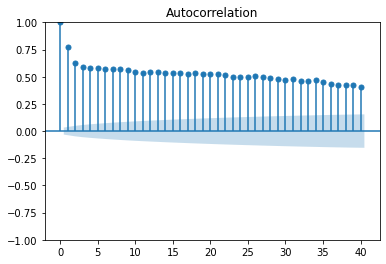

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(temperature['temp'], lags=40);

There is a quick drop in autocorrelation values, further affirming our assumption that there is no trend. Of course, the series is also not stationary given the high autocorrelation over all 40 lags.

Let's try a difference of order 1 and observe the resulting ACF plot. This is actually likely to work well for stationarizing the data since there does not appear to be a seasonality of larger size based on the above plot.

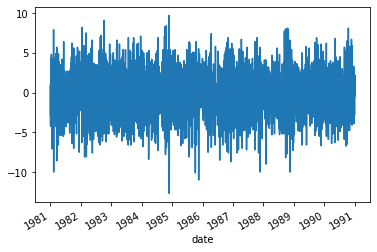

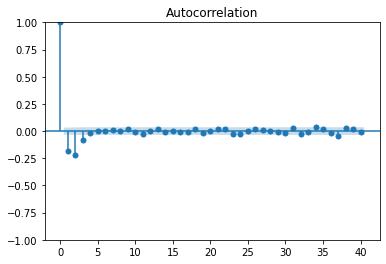

In [26]:
diffed_temp = temperature['temp'].diff(1)

diffed_temp.plot()
plot_acf(diffed_temp.dropna(), lags=40);

A difference of order 1 seems to be perfectly sufficient for stationarizing the data given this result. The autocorrelations being small and patternless are a strong indication that the 1-differenced series is stationary.

In [27]:
run_adftest(diffed_temp.dropna())

Dickey-Fuller Test
Test Statistic: -18.028224167992363
p-value: 2.6815618226745638e-30
Critical Values:
	1%: -3.432155722391455 - The data is stationary with 99% confidence
	5%: -2.8623378673761084 - The data is stationary with 95% confidence
	10%: -2.567194717193812 - The data is stationary with 90% confidence


# ARIMA

The ARIMA model is a combination of three components:

> **AR**: Auto-Regressive (order `p`)

> **I**: Integrated (order `d`)

> **MA**: Moving Average (order `q`)

For the ARIMA model to be applied to a time series, it must be made stationary. More specifically, the time series after differencing with order `d` must be stationary. This is because ARIMA is a linear regression model that uses its own lags as predictors. Linear regression models work best when the predictors are not correlated and independent of one another. Trends and seasonality imply that time series valuse are dependent on previous values.

The above use of differencing (which is possibly unnecessary) to enforce stationarity is the first step to applying the ARIMA model. In fact, this step corresponds to the **I** (integrated) portion of ARIMA. The "order d" of ARIMA is the difference order. For the air passengers data, we determined that `d=2`. For the temperature data, we determined that `d=1`.

Now we can consider the other two portions - AR and MA - both of which were mentioned in the previous lecture but here we will view them in a different context and notation.

## Model Identification

The ACF plot we used earlier can actually be an indicator of which components of ARIMA will likely be useful for constructing a model of the data. These trends and their corresponding model are listed below (taken from [the Wikipedia article on the  Box-Jenkins Method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method)):

Shape | Indicated Model
--- | ---
Exponential, decay to zero | AR - Use PACF plot to identify order
Alternating positive and negative, decaying to zero | AR - Use PACF plot to identify order
One or more spikes, rest are essentially zero  | MA - Order identified by where plot becomes zero
Decay, starting after a few lags | ARMA
All zero or close to zero | Data is essentially random
High values at fixed intervals | Include seasonal autoregressive term / difference
No decay to zero | The series is not stationary

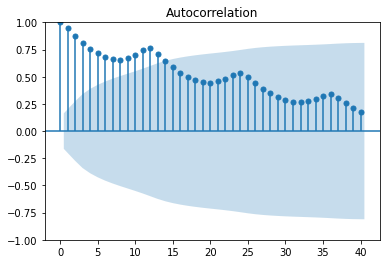

In [28]:
plot_acf(series, lags=40);

This particular ACF does not clearly falls into any one of the above categories, but it is probably accurate to say that there is a decay starting after a few lags (so AR and MA will be used) and there are high values at fixed intervals (so seasonality should be accounted for).

As a side note, seasonality can be addressed in ways other than differencing (even what we did here does not remove the seasonality of the data), but we are not covering those here.

## Auto-Regression (AR)

Auto-regression is a linear regression model based on the most recent `p` values. Formally this is written as

$$
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \epsilon_t
$$

The beta $\beta$ terms are the weights applied to each of the previous values $y_{t-i}$. Epsilon $\epsilon_t$ is the residual error at time $t$. This is simply another way of writing what we saw last lecture when we contextualized our equation in terms of y-"hat": $\hat{y_t} = y_t + \epsilon_t$. That is, $\epsilon_t$ is the difference between our prediction $\hat{y_t}$ and the actual value $y_t$.

The simplest AR model is AR(1), including only the most recent value at time $t-1$. Mathematically:
$$
y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t
$$

There are a number of ways of determining what the value of `p` should be, i.e. the order of auto-regression to use for your time series. The simplest is to plot the partial autocorrelation function of the (stationarized) time series and **find the point just before the partial autocorrelations goes below 0 or into the highlighted region**. Generally this should be a small integer, either 0, 1, or 2. This essentially indicates what the most significant terms are in the auto-regression model.


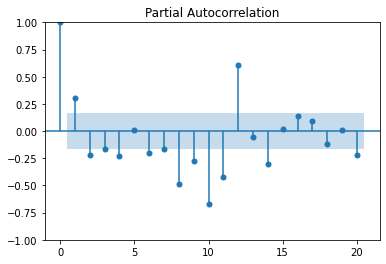

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diffed_series.dropna(), lags=20);

Based on the above plot, we would choose `p=1`, though we may have to experiment with a few values.



## Moving Average (MA)

The Moving Average (MA) model is defined as:

$$
y_t = \mu + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q}
$$

where $\mu$ is $E(y_t)$ and each $\epsilon_i$ is the residual error for time $i$. This means the MA model depends not on the previous data values, but rather the previous forecast errors. Specifically, a MA model with order `q` uses the previous `q` forecast errors.

Very common is the model MA(1):
$$
y_t = \mu + \epsilon_t + \phi_1 \epsilon_{t-1}
$$

Much like how we looked at the PACF plot for determining the value of `p`, we can **look at the ACF plot** for the value of `q`.

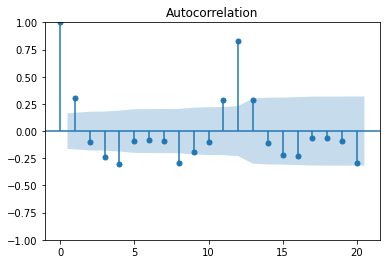

In [30]:
plot_acf(diffed_series.dropna(), lags=20);

Based on the above plot, we would choose `q=1`.

## ARMA and Variations of ARIMA

Not surprisingly, ARMA is a combination of AR and MA. The mathematical model literally just adds them together:

$$
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p}
$$
$$
+ \mu + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q}
$$
$$
+ \epsilon_t
$$

This is actually also the mathematical model for ARIMA. ARIMA simply differences the time series by order `d` before applying ARMA.

Because ARIMA is a combination of a few models, each can be expressed in the form of ARIMA(`p`,`d`,`q`):

> ARIMA(1, 0, 0): AR(1), first-order auto-regressive model

> ARIMA(0, 0, 1): MA(1), first-order moving average model

> ARIMA(0, 1, 0): random walk

> ARIMA(1, 1, 0): differenced AR(1)

> ARIMA(0, 1, 1): differenced MA(1), equivalent to exponential smoothing

# Applying the ARIMA Model



With `p`, `d`, and `q` estimated via the above methods, we can finally try training the ARIMA model and plotting the results.

In [31]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p = 1
d = 1
q = 1

train_data = detrended_series # Diff will be applied by ARIMA

# Train the model and get predictions
model = ARIMA(train_data, order=(p, d, q)).fit()
predictions = model.predict(start=d, typ='levels') # 'levels' keeps original scaling when differencing is used!

# Compute error
mse = mean_squared_error(train_data.iloc[d:], predictions)

# Plot results
scaled_predictions = pd.Series(predictions, copy=True) # convert to Series
scaled_predictions = scaled_predictions * (m * scaled_predictions.index.values + b) # "de-de-trend"

series.passengers.plot()
scaled_predictions.plot()
print(mse)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


## Check Residuals

Recall that ideally our model should have residuals that look like white noise. We can check this by plotting the residuals themselves. How close the plots is to white noise can be hard to interpret just from the plot itself, so plotting a histogram of the residuals to see how close the result is to a standard normal distribution is more robust.

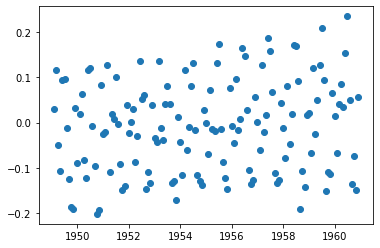

In [32]:
plt.scatter(x=scaled_predictions.index.values, y=model.resid)

(array([ 6., 22., 16., 13., 25., 22., 17., 13.,  7.,  2.]),
 array([-0.20202912, -0.1583315 , -0.11463389, -0.07093628, -0.02723867,
         0.01645894,  0.06015656,  0.10385417,  0.14755178,  0.19124939,
         0.234947  ]),
 <BarContainer object of 10 artists>)

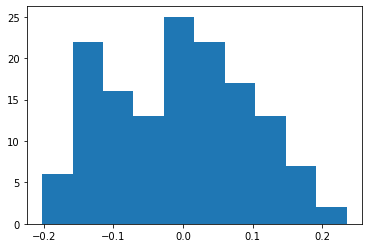

In [33]:
plt.hist(model.resid)

The above histogram is close to normal (slight skew to the left), so some tweaking of the model parameters may be warranted here.

## Model Checking with Train and Test Sets

A more typical way of assessing the accuracy of your model in a machine learning context is to split the data into two sets: the training set and the test set. This allows you to fit the model on the training set so that you have confirmed actual values to allow the model to predict so you can then determine how accurate those predictions are. Often the training set is a good majority of the data while the test set in the remaining portion.

Since we are dealing with time series here, we must ensure that the train and test data are simply partitions of the original data. That is, the order must be maintained because this is a time series where order matters. Libraries like `sklearn` can split data into train and test but they typically do so by randomly shuffling the data which does not work here.

C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Text(0.5, 1.0, 'MSE: 0.03413257126273825')

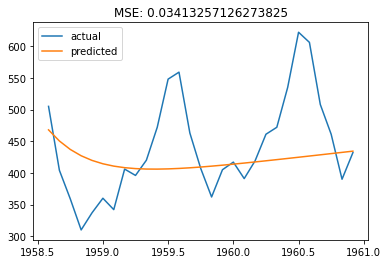

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p = 1
d = 1
q = 1

split_value = int(0.8 * len(detrended_series))

train_data = detrended_series.iloc[:split_value]
test_data = detrended_series.iloc[split_value:]

# Train the model and get predictions
model = ARIMA(train_data, order=(p, d, q)).fit()
predictions = model.predict(start=split_value, end=len(detrended_series)-1, typ='levels')

# Compute error between test data and model's predictions
mse = mean_squared_error(test_data, predictions)

# Plot results
scaled_predictions = pd.DataFrame(predictions, columns=['predictions'], copy=True)
scaled_predictions['time'] = detrended_series.index.values[split_value:]
scaled_predictions.set_index('time', inplace=True)
scaled_predictions['predictions'] = scaled_predictions['predictions'] * (m * scaled_predictions.index.values + b) # "de-de-trend"

plt.plot(series.passengers.iloc[split_value:], label='actual')
plt.plot(scaled_predictions, label='predicted')
plt.legend()
plt.title(f"MSE: {mse}")

## Forecasting

With the model finally estimated using ARIMA, we can use the model to forecast the future. Using `plot_predict` on the resulting model will very nicely plot the predictions for the given data as well as forecasts for future data within a shaded confidence interval. This works when no transformations have been performed on the data being trained on.

Since we detrended the series ourselves before training ARIMA, we have to manually plot the forecasts due to the rescaling that needs to be done.

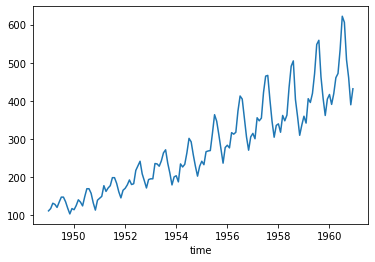

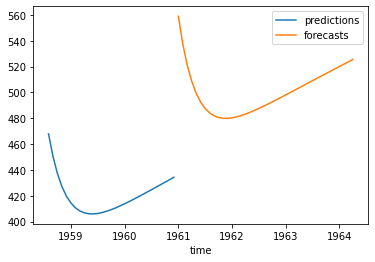

In [35]:
forecasts, err, conf_int = model.forecast(steps=40)

# Determine the time delta so we can calculate next timestamps
# relative to the last time in the original data
first_two_times = series.index.values[0:2]
time_delta = first_two_times[1]-first_two_times[0]
last_time = series.index.values[-1]

# Calculate times for the forecasts
forecast_times = []
for i in range(1,len(forecasts)+1):
  forecast_times.append(last_time + i * time_delta)

# Scale the forecasts
forecast_series = pd.Series(forecasts, index=forecast_times)
scaled_forecasts = forecast_series * (m * forecast_series.index.values + b)

# Plot
series.passengers.plot(label='actual')
scaled_predictions.plot(label='predictions')
scaled_forecasts.plot(label='forecasts')
plt.legend()

C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ddalton\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


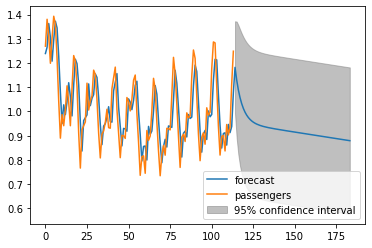

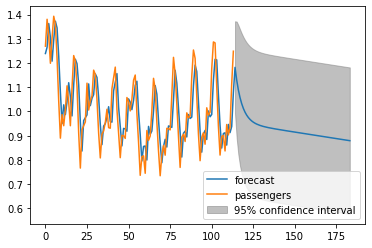

In [36]:
model.plot_predict(start=1, end=len(detrended_series)+40)